In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("../data/predictive_maintenance.csv")

# Preview data
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [60]:
# Shape and missing values
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.columns = df.columns.str.replace(r"[\[\]<>]", "", regex=True)
df = df.drop(columns=["failure_type"])
print(df.columns.tolist())
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

# Data types and class distribution
df.info()
print("\nTarget distribution:\n", df["target"].value_counts())


['udi', 'product_id', 'type', 'air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'target']
Shape: (10000, 9)

Missing values:
 udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
target                   0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    10000 non-null  int64  
 1   product_id             10000 non-null  object 
 2   type                   10000 non-null  object 
 3   air_temperature_k      10000 non-null  float64
 4   process_temperature_k  10000 non-null  float64
 5   rotational_speed_rpm   10000 non-null  int64  
 6   torque_nm              10000 non-null  f

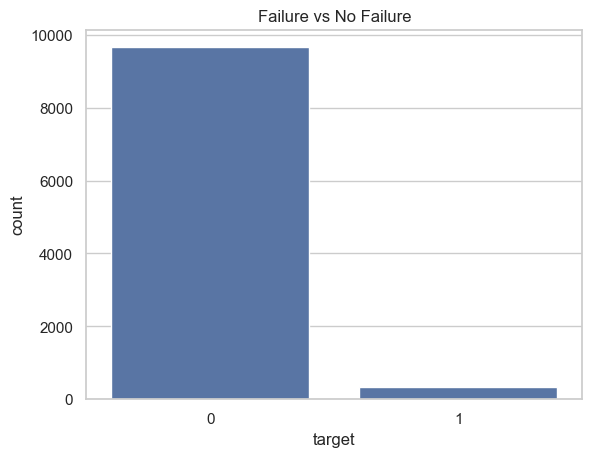

In [61]:
# Visualize class balance
sns.countplot(x="target", data=df)
plt.title("Failure vs No Failure")
plt.show()


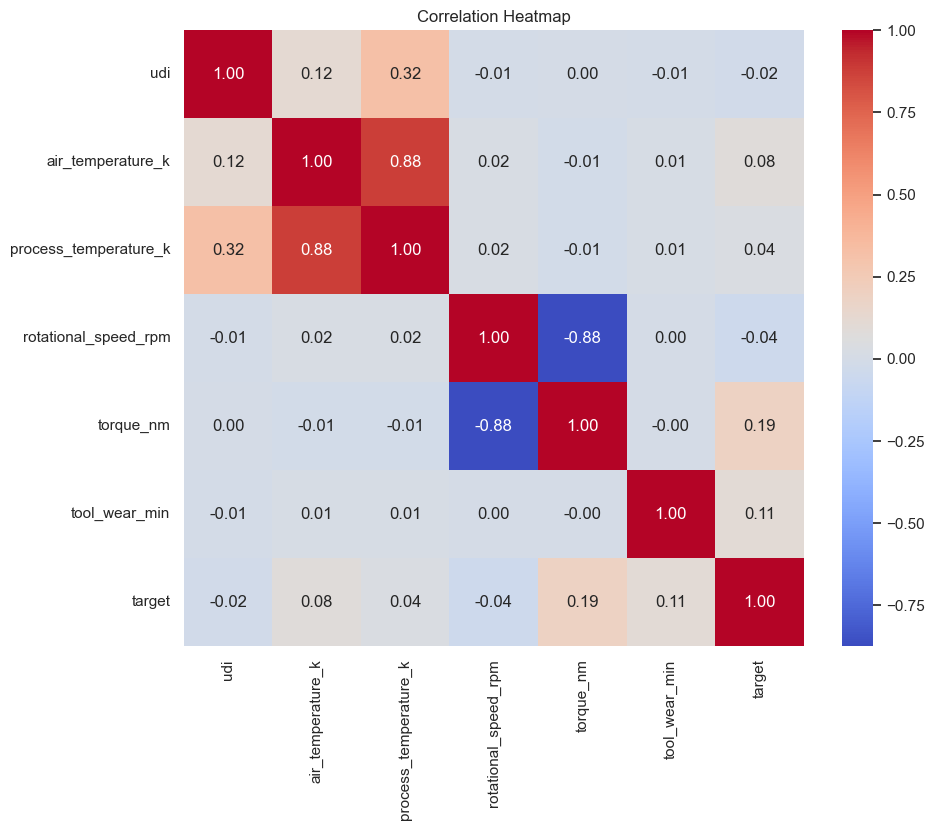

In [62]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [63]:
# Drop non-informative columns (example: ID)
df = df.drop(columns=["udi", "product_id"])

# One-hot encode 'Type' if it's categorical
df = pd.get_dummies(df, columns=["type"], drop_first=True)

# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]


In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [65]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


c:\Users\LexyC\OneDrive\Documents\Career Portfolio Projects\predictive-maintenance\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:53:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.89      0.75      0.82        68

    accuracy                           0.99      2000
   macro avg       0.94      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000



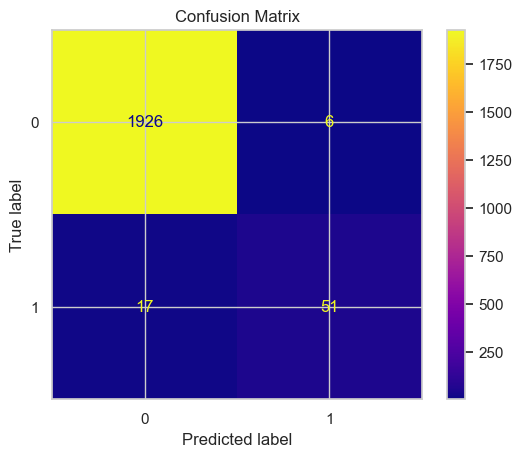

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

# Print report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="plasma")
plt.title("Confusion Matrix")
plt.show()


In [67]:
predictions_df = X_test.copy()
predictions_df["Actual"] = y_test.values
predictions_df["Predicted"] = y_pred
predictions_df.to_csv("../outputs/predictions.csv", index=False)


<Figure size 1000x600 with 0 Axes>

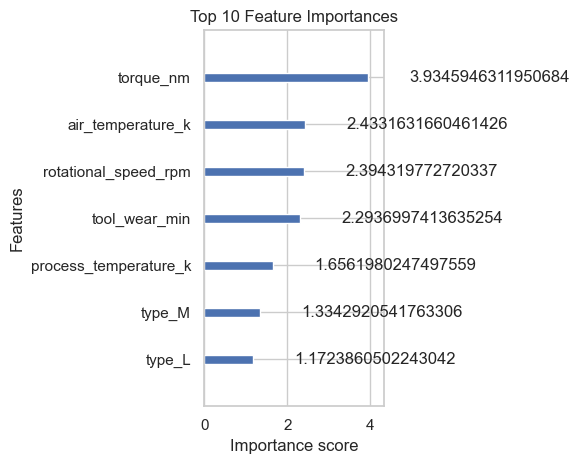

In [68]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type="gain", title="Top 10 Feature Importances")
plt.tight_layout()
plt.savefig("../outputs/feature_importance.png")
plt.show()

In [69]:
# Make sure all features are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

print(X_train.dtypes)


air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
type_L                      bool
type_M                      bool
dtype: object


In [70]:
# Ensure all features are float64 for SHAP compatibility
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')


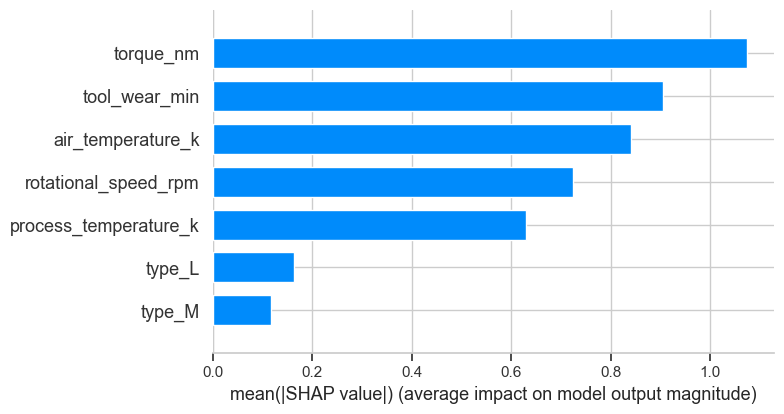

In [71]:
import shap

# Create explainer and shap values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Save bar-style SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("../outputs/shap_summary_bar.png")
plt.show()


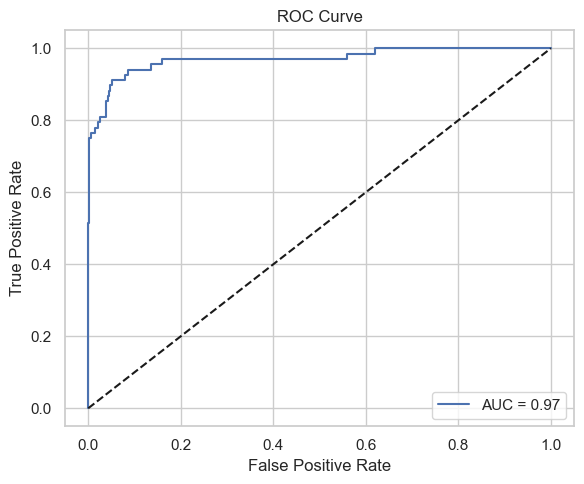

In [72]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for ROC
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot and save
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/roc_curve.png")
plt.show()


                     accuracy       auc
XGBoost                0.9885  0.969972
Random Forest          0.9840  0.968210
Logistic Regression    0.9685  0.899457


c:\Users\LexyC\OneDrive\Documents\Career Portfolio Projects\predictive-maintenance\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:53:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


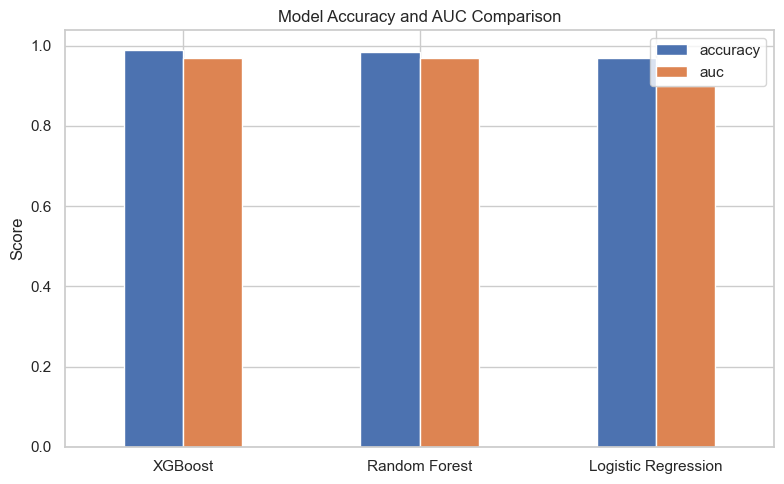

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, m.predict_proba(X_test)[:, 1])
    results[name] = {"accuracy": acc, "auc": auc}

# Convert to DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values("auc", ascending=False)
print(comparison_df)

# Plot and save
comparison_df.plot(kind='bar', figsize=(8, 5), title="Model Accuracy and AUC Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/model_comparison.png")
plt.show()
